In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import StepLR
import yaml
import numpy as np

### Dataset

In [4]:
class Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

### CNN

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Sequential(
            nn.Linear(64 * 64 * 64, 512),
            nn.ReLU()
            )
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        
        #flatten
        x = x.view(-1, 64 * 64 * 64)
        
        #fc layer
        x = self.fc1(x)
        x = self.fc2(x)
        
        return abs(x) #return x,y coordinates in range[0,1]

### Load image and Label

In [ ]:
images_path_train = []
labels_train = []
label_path_train = "train_needle/labels"
for label in os.listdir(label_path_train):
    with open(os.path.join(label_path_train, label),'r', encoding='utf-8') as file:
        data = yaml.safe_load(file)
        position = [data['x']/480,data['y']/640]
        labels_train.append(position)
for img_file in os.listdir("train_needle/images"):
    images_path_train.append(os.path.join("train_needle/images", img_file))

images_path_test = []
labels_test = []
label_path_test = "test_needle/labels"
for label in os.listdir(label_path_test):
    with open(os.path.join(label_path_test, label),'r', encoding='utf-8') as file:
        data = yaml.safe_load(file)
        position = [data['x']/480,data['y']/640]
        labels_test.append(position)
for img_file in os.listdir("test_needle/images"):
    images_path_test.append(os.path.join("test_needle/images", img_file))

### Create dataset, and do data pre-preprocessing

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),           
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomGrayscale(p=0.2)
])
images_path_train = np.array(images_path_train)
labels_train = np.array(labels_train)
dataset_train = Dataset(images_path_train, labels_train, transform_train)
train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)

transform_test = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
images_path_test = np.array(images_path_test)
labels_test = np.array(labels_test)
dataset_test = Dataset(images_path_test, labels_test, transform_test)
test_loader = DataLoader(dataset_test, batch_size=8, shuffle=False)
images_path_train = np.array(images_path_train)

### Train model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

num_epochs = 100 
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        labels = labels.float().to(device)
        images = images.to(device)
        optimizer.zero_grad()
        output_train = model(images)
        loss = criterion(output_train, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.6f}')
torch.save(model, 'model_needle.pth')

### Test Model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('model_needle.pth')
model.eval() 
criterion = nn.MSELoss()
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.float().to(device)
        images = images.to(device)
        output_test = model(images)
        loss = criterion(output_test, labels)
        test_loss += loss.item()

# Calculate the average test loss
average_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {average_test_loss:.6f}')

C:\Users\user\AppData\Local\Temp\ipykernel_10384\3420408277.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_needle.pth')


Test Loss: 0.000074


### Visualize the result

C:\Users\user\AppData\Local\Temp\ipykernel_10384\704379938.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model_needle.pth")


Prediction: [0.8026113  0.42139518]


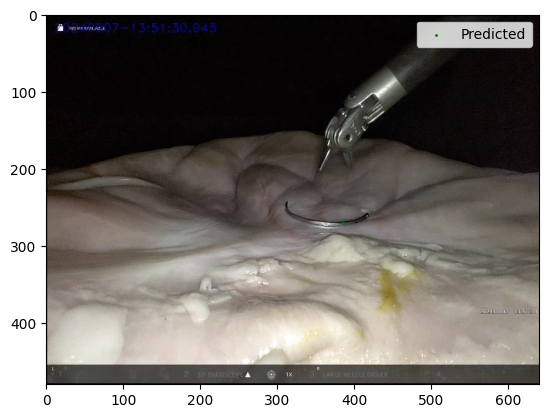

Prediction: [0.78806525 0.40714154]


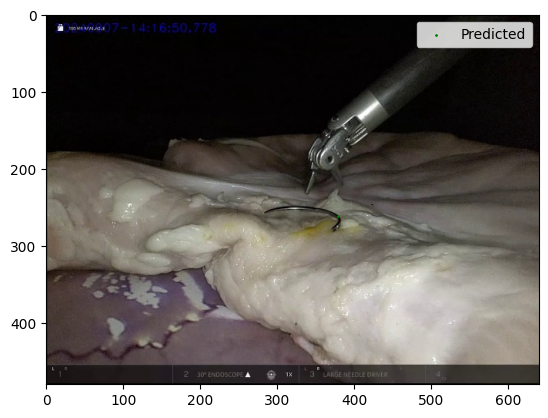

Prediction: [0.7820941  0.41005838]


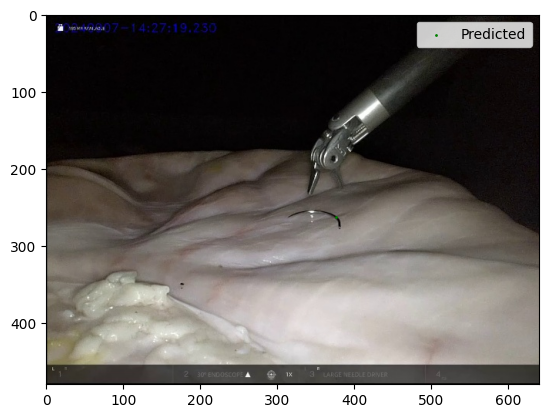

Prediction: [0.4662035  0.48100063]


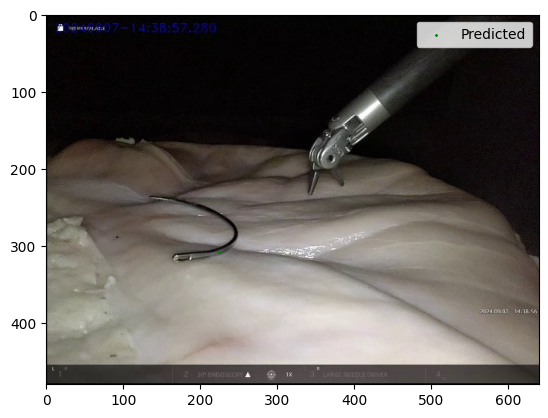

Prediction: [0.45061213 0.47256753]


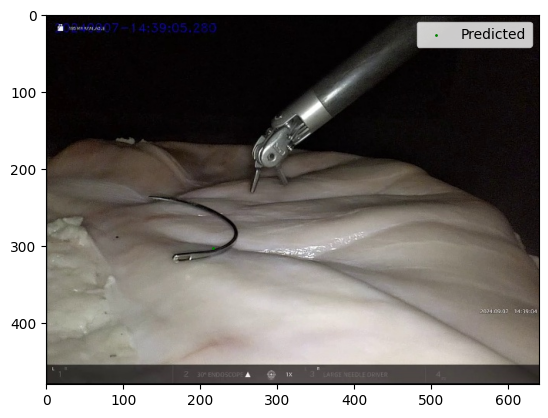

Prediction: [0.47754484 0.45556873]


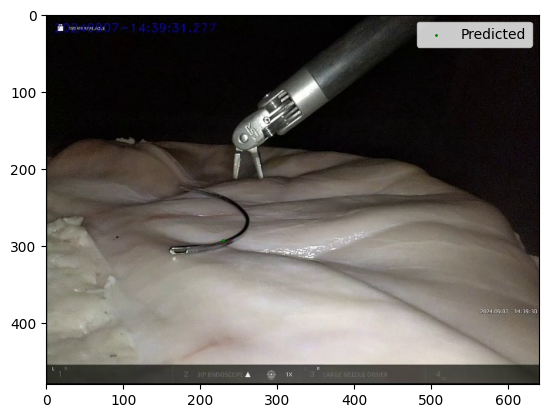

Prediction: [0.69678026 0.428784  ]


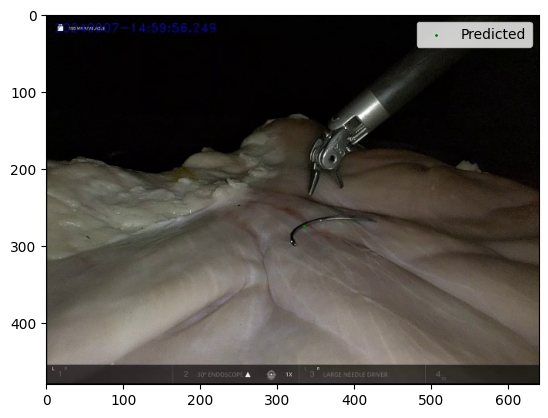

Prediction: [0.69798875 0.42700064]


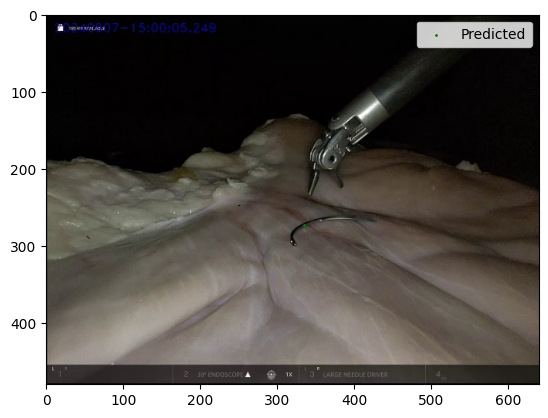

Prediction: [0.71833366 0.45942596]


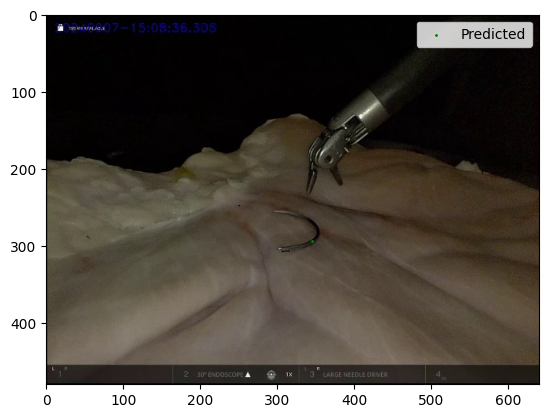

Prediction: [0.7184274  0.45961314]


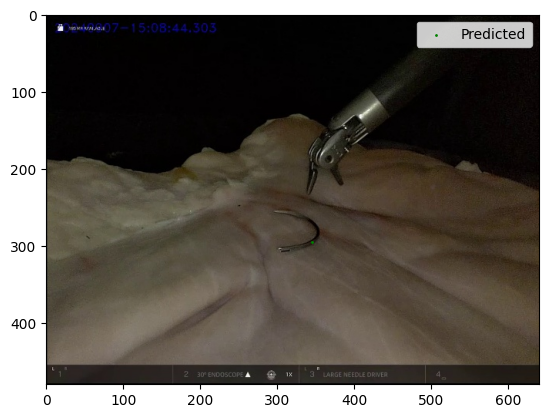

Prediction: [0.6018864  0.40315878]


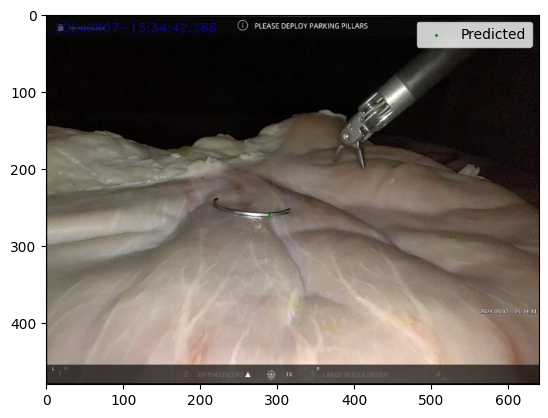

Prediction: [0.69647133 0.3964006 ]


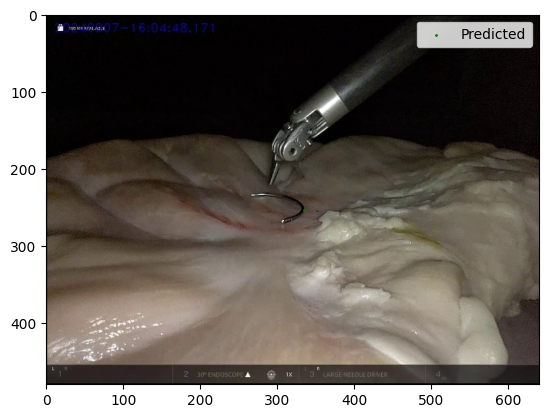

Prediction: [0.6482044 0.405839 ]


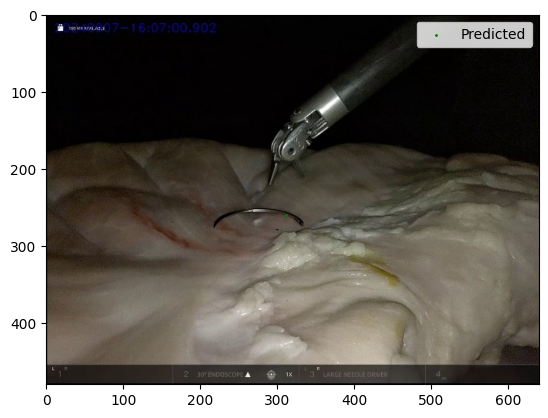

Prediction: [0.6360984 0.3932552]


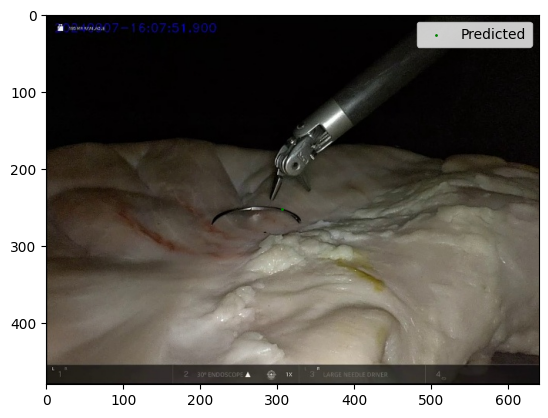

Prediction: [0.6230762 0.3927049]


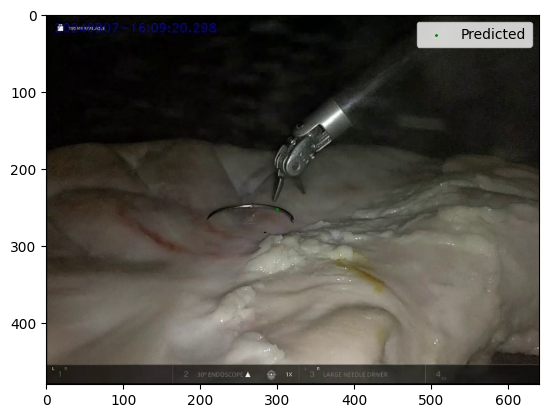

Prediction: [0.50897765 0.42770532]


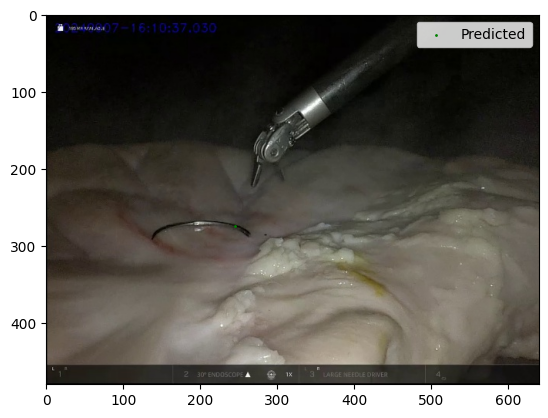

In [13]:
import cv2
model = torch.load("model_needle.pth")
model.eval()
for image_name in os.listdir("test_needle/images"):   
    image_path = os.path.join("test_needle/images",image_name)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_image = Image.fromarray(image_rgb)  # 转换为 PIL 图像
    input_tensor = transform_test(input_image).unsqueeze(0).to(device)  # 添加 batch 维度

    # 推理
    with torch.no_grad():  # 禁用梯度计算
        prediction = model(input_tensor)
    # 解析预测结果（假设 prediction 是 [x, y] 坐标）
    prediction = prediction.squeeze().cpu().numpy()  # 转换为 NumPy 数组
    print("Prediction:", prediction)

    # 显示图像
    plt.imshow(image_rgb)

    # 绘制预测点（假设 prediction 是归一化坐标 [0, 1]）
    plt.scatter(prediction[0] * image.shape[0], prediction[1] * image.shape[1], 
                c='green', label='Predicted', s=1, marker='o')

    plt.legend()
    plt.pause(0.001)
    plt.close()
